# Modeling and Simulation in Python


Copyright 2018 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Inferring thermal resistance and thermal mass of a wall

This case study is based on Gori, Marincioni, Biddulph, Elwell, "Inferring the thermal resistance and effective thermal mass distribution of a wall from in situ measurements to characterise heat transfer at both the interior and exterior surfaces", *Energy and Buildings*, Volume 135, 15 January 2017, Pages 398-409, [which I downloaded here](https://www.sciencedirect.com/science/article/pii/S0378778816313056).
    
The authors put their paper under a Creative Commons license, and [make their data available here](http://discovery.ucl.ac.uk/1526521).  I thank them for their commitment to open, reproducible science, which made this case study possible.

The goal of their paper is to model the thermal behavior of a wall as a step toward understanding the "performance gap between the expected energy use of buildings and their measured energy use".  The wall they study is identified as the exterior wall of an office building in central London, [not unlike this one](https://www.google.com/maps/@51.5269375,-0.1303666,3a,75y,90h,88.17t/data=!3m6!1e1!3m4!1sAoAXzN0mbGF9acaVEgUdDA!2e0!7i13312!8i6656).

The following figure shows the scenario and their model:

![Figure 2](https://ars.els-cdn.com/content/image/1-s2.0-S0378778816313056-gr2.jpg)

On the interior and exterior surfaces of the wall, they measure temperature and heat flux over a period of three days.  They model the wall using two thermal masses connected to the surfaces, and to each other, by thermal resistors.

The primary methodology of the paper is a Bayesian method for inferring the parameters of the system (two thermal masses and three thermal resistances).

The primary result is a comparison of two models: the one shown here with two thermal masses, and a simpler model with only one thermal mass.  They find that the two-mass model is able to reproduce the measured fluxes substantially better.

Tempting as it is, I will not replicate their method for estimating the parameters.  Rather, I will

1. Implement their model and run it with their estimated parameters, to replicate the results, and 

2. Use SciPy's `leastsq` to see if I can find parameters that yield lower errors (root mean square).

`leastsq` is a wrapper for some venerable FORTRAN code that runs ["a modification of the Levenberg-Marquardt algorithm"](https://www.math.utah.edu/software/minpack/minpack/lmdif.html), which is one of my favorites ([really](http://allendowney.com/research/model)).

Implementing their model in the ModSimPy framework turns out to be straightforward.  The simulations run fast enough even when we carry units through the computation.  And the results are visually similar to the ones in the original paper.

I find that `leastsq` is not able to find parameters that yield substantially better results, which suggest that the estimates in the paper are at least locally optimal.


### Loading the data

First I'll load the units we need from Pint.

In [2]:
m = UNITS.meter
K = UNITS.kelvin
W = UNITS.watt
J = UNITS.joule
degC = UNITS.celsius

<Unit('degC')>

Read the data.

In [3]:
data = pd.read_csv('data/DataOWall.csv', parse_dates=[0], index_col=0, header=0, skiprows=[1,2])
data.head()

,Q_in,Q_out,T_int,T_ext
2014-10-05 16:30:00,10.994,6.840,16.92,14.68
2014-10-05 16:35:00,10.952,6.012,16.92,14.69
2014-10-05 16:40:00,10.882,7.040,16.93,14.66
2014-10-05 16:45:00,10.798,8.880,16.93,14.59
2014-10-05 16:50:00,10.756,10.491,16.94,14.50


The index contains Pandas `Timestamp` objects, which is good for dealing with real-world dates and times, but not as good for running the simulations, so I'm going to convert to seconds.

In [4]:
timestamp_0 = get_first_label(data)

Timestamp('2014-10-05 16:30:00')

Subtracting the first `Timestamp` yields `Timedelta` objects:

In [5]:
time_deltas = data.index - timestamp_0

TimedeltaIndex(['0 days 00:00:00', '0 days 00:05:00', '0 days 00:10:00',
                '0 days 00:15:00', '0 days 00:20:00', '0 days 00:25:00',
                '0 days 00:30:00', '0 days 00:35:00', '0 days 00:40:00',
                '0 days 00:45:00',
                ...
                '2 days 23:10:00', '2 days 23:15:00', '2 days 23:20:00',
                '2 days 23:25:00', '2 days 23:30:00', '2 days 23:35:00',
                '2 days 23:40:00', '2 days 23:45:00', '2 days 23:50:00',
                '2 days 23:55:00'],
               dtype='timedelta64[ns]', length=864, freq=None)

Then we can convert to seconds and replace the index.

In [6]:
data.index = time_deltas.days * 86400 + time_deltas.seconds
data.head()

,Q_in,Q_out,T_int,T_ext
0,10.994,6.840,16.92,14.68
300,10.952,6.012,16.92,14.69
600,10.882,7.040,16.93,14.66
900,10.798,8.880,16.93,14.59
1200,10.756,10.491,16.94,14.50


The timesteps are all 5 minutes:

In [7]:
np.all(np.diff(data.index) == 300)

True

Mark the columns of the `Dataframe` with units.

In [8]:
data.Q_in.units = W / m**2
data.Q_out.units = W / m**2
data.T_int.units = degC
data.T_ext.units = degC

Plot the measured fluxes.

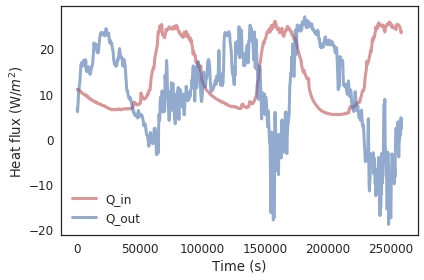

In [9]:
plot(data.Q_in, color='C2')
plot(data.Q_out, color='C0')
decorate(xlabel='Time (s)',
         ylabel='Heat flux (W/$m^2$)')

Plot the measured temperatures.

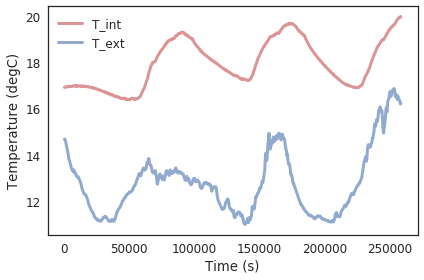

In [10]:
plot(data.T_int, color='C2')
plot(data.T_ext, color='C0')
decorate(xlabel='Time (s)',
         ylabel='Temperature (degC)')

### Params and System objects

Here's a `Params` object with the [estimated parameters from the paper](https://www.sciencedirect.com/science/article/pii/S0378778816313056#tbl0005).

In [11]:
params = Params(
    R1 = 0.076 * m**2 * K / W,
    R2 = 0.272 * m**2 * K / W,
    R3 = 0.078 * m**2 * K / W,
    C1 = 212900 * J / m**2 / K,
    C2 = 113100 * J / m**2 / K)

,values
R1,0.076 kelvin * meter ** 2 / watt
R2,0.272 kelvin * meter ** 2 / watt
R3,0.078 kelvin * meter ** 2 / watt
C1,212900.0 joule / kelvin / meter ** 2
C2,113100.0 joule / kelvin / meter ** 2


Pass the `Params` object `make_system`, which computes `init`, packs the parameters into `Series` objects, and computes the interpolation functions.


In [12]:
def make_system(params, data):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    R1, R2, R3, C1, C2 = params
    
    init = State(T_C1 = Quantity(16.11, degC),
                 T_C2 = Quantity(15.27, degC))
    
    ts = data.index
    t_end = ts[-1]
    
    return System(init=init,
                  R=Series([R1, R2, R3]),
                  C=Series([C1, C2]),
                  T_int_func=interpolate(data.T_int),
                  T_ext_func=interpolate(data.T_ext),
                  t_end=t_end, ts=ts)

Make a `System` object

In [13]:
system = make_system(params, data)

,values
init,T_C1 16.11 degC T_C2 15.27 degC dtype: o...
R,0 0.076 kelvin * meter ** 2 / watt 1 0.2...
C,0 212900.0 joule / kelvin / meter ** 2 1 ...
T_int_func,<function interpolate.<locals>.<lambda> at 0x7...
T_ext_func,<function interpolate.<locals>.<lambda> at 0x7...
t_end,258900
ts,"Int64Index([ 0, 300, 600, 900, ..."


Test the interpolation function:

In [14]:
system.T_ext_func(0), system.T_ext_func(150), system.T_ext_func(300)

(<Quantity(14.68, 'degC')>,
 <Quantity(14.684999999999999, 'degC')>,
 <Quantity(14.69, 'degC')>)

### Implementing the model

Next we need a slope function that takes instantaneous values of the two internal temperatures and computes their time rates of change.

The slope function gets called two ways.

* When we call it directly, `state` is a `State` object and the values it contains have units.

* When `run_ode_solver` calls it, `state` is an array and the values it contains don't have units.

In the second case, we have to apply the units before attempting the computation.  `require_units` applies units if necessary:

The following function computes the fluxes between the four zones.

In [16]:
def compute_flux(state, t, system):
    """Compute the fluxes between the walls surfaces and the internal masses.
    
    state: State with T_C1 and T_C2
    t: time in seconds
    system: System with interpolated measurements and the R Series
    
    returns: Series of fluxes
    """
    # unpack the temperatures and apply units
    T_C1, T_C2 = state
    T_C1 = require_units(T_C1, degC)
    T_C2 = require_units(T_C2, degC)
        
    # compute a series of temperatures from inside out
    T_int = system.T_int_func(t)
    T_ext = system.T_ext_func(t)
    T = Series([T_int, T_C1, T_C2, T_ext])
    
    # compute differences of adjacent temperatures
    T_diff = np.diff(T)

    # compute fluxes between adjacent compartments
    Q = T_diff / system.R
    return Q

We can test it like this.

In [17]:
compute_flux(system.init, 0, system)

0    -10.657894736842135 delta_degC * watt / kelvin...
1    -3.0882352941176463 delta_degC * watt / kelvin...
2    -7.564102564102562 delta_degC * watt / kelvin ...
dtype: object

Here's a slope function that computes derivatives of `T_C1` and `T_C2`

In [18]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object
    
    returns: derivatives of y and v
    """
    Q = compute_flux(state, t, system)

    # compute the net flux in each node
    Q_diff = np.diff(Q)
        
    # compute the rate of change of temperature
    dQdt = Q_diff / system.C
    return dQdt

Test the slope function with the initial conditions.

In [19]:
slope_func(system.init, system.ts[1], system)

0     3.555499973097458e-05 delta_degC * watt / joule
1    -3.844086774341106e-05 delta_degC * watt / joule
dtype: object

Run the simulation, generating estimates for the time steps in the data.

In [20]:
results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
details

,values
sol,None
t_events,[]
nfev,254
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


Here's what the results look like.

In [21]:
results.head()

,T_C1,T_C2
0,16.110000,15.270000
300,16.120516,15.258636
600,16.130820,15.247580
900,16.140992,15.235209
1200,16.150975,15.220746


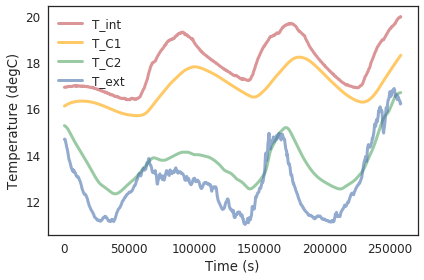

In [22]:
def plot_results(results, data):
    plot(data.T_int, color='C2')
    plot(results.T_C1, color='orange')
    plot(results.T_C2, color='C1')
    plot(data.T_ext, color='C0')
    decorate(xlabel='Time (s)',
             ylabel='Temperature (degC)')
    
plot_results(results, data)

These results are similar to what's in the paper:

![Figure 5](https://ars.els-cdn.com/content/image/1-s2.0-S0378778816313056-gr5.jpg).  

To get the estimated fluxes, we have to go through the results and basically do the flux calculation again.

In [23]:
def recompute_fluxes(results, system):
    """Compute fluxes between wall surfaces and internal masses.
    
    results: Timeframe with T_C1 and T_C2
    system: System object
    
    returns: Timeframe with Qm_in and Qm_out
    """
    Q_frame = TimeFrame(index=results.index, columns=['Qm_in', 'Qm_out'])
    
    for t, row in results.iterrows():
        Q = compute_flux(row, t, system)
        
        Q_frame.row[t] = (-Q[0].magnitude, 
                          -Q[2].magnitude)
        
    return Q_frame
            
Q_frame = recompute_fluxes(results, system)
Q_frame.head()

,Qm_in,Qm_out
0,10.6579,7.5641
300,10.5195,7.2902
600,10.5155,7.53308
900,10.3817,8.2719
1200,10.3819,9.24034


Let's see how the estimates compare to the data.

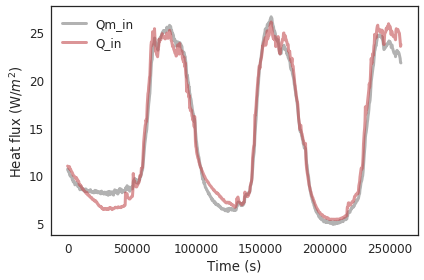

In [24]:
def plot_Q_in(Q_frame, data):
    plot(Q_frame.Qm_in, color='gray')
    plot(data.Q_in, color='C2')
    decorate(xlabel='Time (s)',
             ylabel='Heat flux (W/$m^2$)')
    
plot_Q_in(Q_frame, data)

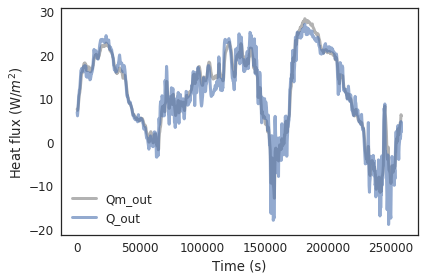

In [25]:
def plot_Q_out(Q_frame, data):
    plot(Q_frame.Qm_out, color='gray')
    plot(data.Q_out, color='C0')
    decorate(xlabel='Time (s)',
             ylabel='Heat flux (W/$m^2$)')
    
plot_Q_out(Q_frame, data)

These results are also similar to what's in the paper (the bottom row):

![Figure 3](https://ars.els-cdn.com/content/image/1-s2.0-S0378778816313056-gr3.jpg)

I'll compute the array of errors, including `Q_in` and `Q_out`:

In [26]:
def compute_error(Q_frame, data):
    error_Q_in = (Q_frame.Qm_in - data.Q_in).astype(float)
    error_Q_out = (Q_frame.Qm_out - data.Q_out).astype(float)
    return np.hstack([error_Q_in, error_Q_out])

In [27]:
errors = compute_error(Q_frame, data)

array([-0.33610526, -0.43247718, -0.36646728, ...,  3.45293108,
        1.58928364,  3.71097458])

Here's the root mean squared error.

In [28]:
print(np.sqrt(np.mean(errors**2)))

1.8330081709528363


### Estimating parameters

Now let's see if we can do any better than the parameters in the paper.

In [125]:
params = Params(
    R1 = 0.076 * m**2 * K / W,
    R2 = 0.272 * m**2 * K / W,
    R3 = 0.078 * m**2 * K / W,
    C1 = 212900 * J / m**2 / K,
    C2 = 113100 * J / m**2 / K)

,values
R1,0.076 kelvin * meter ** 2 / watt
R2,0.272 kelvin * meter ** 2 / watt
R3,0.078 kelvin * meter ** 2 / watt
C1,212900.0 joule / kelvin / meter ** 2
C2,113100.0 joule / kelvin / meter ** 2


Here's an error function that takes a hypothetical set of parameters, runs the simulation, and returns an array of errors.

In [126]:
def error_func(params, data):
    """Run a simulation and return an array of errors.
    
    params: Params object or array
    data: DataFrame
    
    returns: array of float
    """
    print(params)
    system = make_system(params, data)
    results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
    Q_frame = recompute_fluxes(results, system)
    errors = compute_error(Q_frame, data)
    print('RMSE', np.sqrt(np.mean(errors**2)))
    return errors

Testing `error_func`.

In [127]:
errors = error_func(params, data)

R1        0.076 kelvin * meter ** 2 / watt
R2        0.272 kelvin * meter ** 2 / watt
R3        0.078 kelvin * meter ** 2 / watt
C1    212900.0 joule / kelvin / meter ** 2
C2    113100.0 joule / kelvin / meter ** 2
dtype: object
RMSE 1.8330081709528363


array([-0.33610526, -0.43247718, -0.36646728, ...,  3.45293108,
        1.58928364,  3.71097458])

Pass `error_func` to `fit_leastsq` to see if it can do any better.

In [124]:
best_params, details = fit_leastsq(error_func, params, data)

[7.600e-02 2.720e-01 7.800e-02 2.129e+05 1.131e+05]
RMSE 1.8505924115934524
[7.600e-02 2.720e-01 7.800e-02 2.129e+05 1.131e+05]
RMSE 1.8505924115934524
[7.600e-02 2.720e-01 7.800e-02 2.129e+05 1.131e+05]
RMSE 1.8505924115934524
[7.60000011e-02 2.72000000e-01 7.80000000e-02 2.12900000e+05
 1.13100000e+05]
RMSE 1.8555753453523043
[7.60000000e-02 2.72000004e-01 7.80000000e-02 2.12900000e+05
 1.13100000e+05]
RMSE 1.8432262123392518
[7.60000000e-02 2.72000000e-01 7.80000012e-02 2.12900000e+05
 1.13100000e+05]
RMSE 1.901052298632084
[7.60000000e-02 2.72000000e-01 7.80000000e-02 2.12900003e+05
 1.13100000e+05]
RMSE 1.9141948565632672
[7.60000000e-02 2.72000000e-01 7.80000000e-02 2.12900000e+05
 1.13100002e+05]
RMSE 1.9254240170566361
[7.60000006e-02 2.72000019e-01 7.79999992e-02 2.12899980e+05
 1.13100005e+05]
RMSE 1.846084441287066
[7.60000017e-02 2.72000019e-01 7.79999992e-02 2.12899980e+05
 1.13100005e+05]
RMSE 1.8221067418257664
[7.60000006e-02 2.72000023e-01 7.79999992e-02 2.12899980e+05

The search ends normally.

In [123]:
details

,values
fvec,"[-0.3361052367318642, -0.6843824494040387, -0...."
nfev,13
fjac,"[[-2310206065.5804176, -1112552470.6892738, -2..."
ipvt,"[3, 1, 2, 5, 4]"
qtf,"[4.031779346939402, -0.13667226215662664, 1.26..."
cov_x,"[[6.353204439137648e-17, 1.4331161896476686e-1..."
mesg,The relative error between two consecutive ite...
ier,2


In [119]:
details.mesg

'The relative error between two consecutive iterates is at most 0.000000'

The best params are only slightly different from the starting place. 

In [120]:
best_params

,values
R1,0.076000
R2,0.272000
R3,0.078000
C1,212899.990310
C2,113100.012281


Here's what the results look like with the `best_params`.

In [121]:
system = make_system(best_params, data)
results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
Q_frame = recompute_fluxes(results, system)
errors = compute_error(Q_frame, data)
print(np.sqrt(np.mean(errors**2)))

1.7908027900352392


The RMS error is only slightly smaller.

And the results are visually similar.

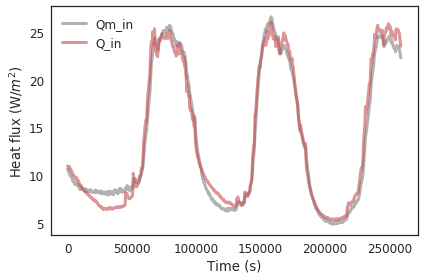

In [85]:
plot_Q_in(Q_frame, data)

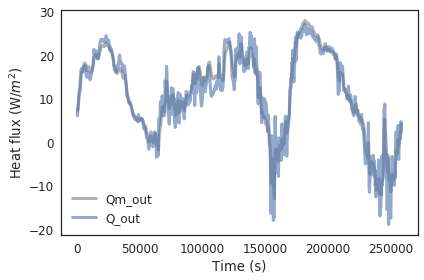

In [86]:
plot_Q_out(Q_frame, data)

**Exercise:** Try starting the model with a different set of parameters and see if it moves toward the parameters in the paper.

I found that no matter where I start, `fit_leastsq` doesn't move far, which suggests that it is not able to optimize the parameters effectively.

### Notes

Notes on working with degC.

Usually I construct a `Quantity` object by multiplying a number and a unit.  With degC, that doesn't work; you get  `OffsetUnitCalculusError: Ambiguous operation with offset unit (degC).`

In [63]:
#16.11 * C 

The problem seems to be that it doesn't know whether you want a temperature measurement or a temperature difference.

You can create a temperature measurement like this.

In [38]:
T = Quantity(16.11, degC)

<Quantity(16.11, 'degC')>

If you convert to Kelvin, it does the right thing.

In [39]:
T.to(K)

<Quantity(289.26, 'kelvin')>

When you subtract temperatures, the results is a temperature difference, indicated by the units.

In [40]:
diff = T - 273.15 * K

<Quantity(16.11, 'delta_degC')>

If you convert a temperature difference to Kelvin, it does the right thing.

In [41]:
diff.to(K)

<Quantity(16.11, 'kelvin')>